In [1]:
import functools
import itertools
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import dnnlib
from training.networks import Generator
from torch_utils import misc

import legacy

from wrapper import StyleGanWrapper, FaceSegmenter, KeyPointDetector, KeyPointDetector2, IDFeatureExtractor, KeyPointHeatMapper
from criterions import * 
from jtj_analysis import *

In [2]:
seed = 8
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

truncation_psi = 1
noise_mode = 'none'
noise_mode = 'const'
device = torch.device('cuda')

zs0 = torch.randn(32, 512, device=device)

# Please setup your own directory, download and put the pre-train models in the required place.
work_dir = './'
cache_dir = work_dir + '/cache/'
cache_path = work_dir + '/cache/jtj_%s.%s.%s.pth'
span_path = work_dir + '/cache/span_%s.%s.pth'
fig_path = '/tmp/figs'

# Download from https://github.com/NVlabs/stylegan2
generator_path = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl'
# Download from https://github.com/zllrunning/face-parsing.PyTorch
segmenter_path = f'{cache_dir}/79999_iter.pth'
# Download from https://github.com/deepinsight/insightface/tree/master/recognition/arcface_torch#model-zoo
extractor_path = f'{cache_dir}/backbone100.pth'

In [3]:
with dnnlib.util.open_url(generator_path) as f:
    official_gan = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
generator = Generator(z_dim=official_gan.z_dim,
        c_dim=official_gan.c_dim,
        w_dim=official_gan.w_dim,
        img_resolution=official_gan.img_resolution,
        img_channels=official_gan.img_channels)
generator.load_state_dict(official_gan.state_dict())

detector = KeyPointDetector().to(device)
stylegan_mapper = StyleGanWrapper(generator).to(device)

def dataloader_to(zs_train, space):
    def mapper(z):
        with torch.no_grad():
            z = z.unsqueeze(0)
            return stylegan_mapper(z, to=space).squeeze(0)
    mapped = list(map(mapper, zs_train))
    dataloader = DataLoader(mapped, batch_size=5)
    return dataloader

def save_pdf(image, path):
    print('saving', path)
    f = plt.figure()
    plt.imshow(image)
    f.gca().set_axis_off()
    f.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    f.gca().xaxis.set_major_locator(plt.NullLocator())
    f.gca().yaxis.set_major_locator(plt.NullLocator())
    f.savefig(path, bbox_inches='tight', pad_inches=0)

def visualize(zs_train, space, magnitude, v_act, selector=[0], s_act=None, save_root=None, steps=[-2, -1, 0, 1, 2]):
    z0 = zs_train
    u0 = stylegan_mapper(z0, to=space)
    v_act = v_act.unsqueeze(0) if v_act.dim() == 2 else v_act
    magnitude = [magnitude] * len(v_act) if isinstance(magnitude, (int, float)) else magnitude
    # V x 1 x u0.shape[1:]
    magnitude = zs_train.new_tensor(magnitude).view((-1,) + (1,) * u0.dim())
    vecs = v_act # fg_bases
    with torch.no_grad():
        for i in selector:
            if i >= vecs.shape[-1]:
                continue
            # print(i, 's = ', s_act[i])
            # V x 1 x u0.shape
            delta = vecs[:, :, i].reshape((len(v_act), 1) + u0.shape[1:])
        
            # 1 x D x 1 ^ u0.shape[1:]
            d = u0.new_tensor(steps).view((1, -1) + (1,) * (u0.dim() - 1))
            # V x D x u0.shape[1:]
            d = d * delta * magnitude
            # B x 1 x 1 x u0.shape[1:]
            u = u0[:, None, None, ...]
            # B x V x D x u0.shape[1:]
            u = u + d
            u = u.flatten(0, 2)
            x = stylegan_mapper(u, from_=space)
            x = transforms.functional.resize(x, (128, 128))
            # B x V x D x 3 x H x W
            x = x.unflatten(0, (len(z0), len(v_act), len(steps)))
            x = x.clamp(0, 1)

            if save_root:
                save_root_path = Path(save_root)
                if not save_root_path.exists():
                    save_root_path.mkdir(parents=True)

                x0 = stylegan_mapper(u0, from_=space)
                x0 = transforms.functional.resize(x0, (128, 128))
                for b in range(x.shape[0]):
                    save_pdf(x0[b].permute(1, 2, 0).cpu().detach(), f'{save_root}/b{b}.pdf')
                    for v in range(x.shape[1]):
                        save_pdf(x[b, v].permute(2, 0, 3, 1).flatten(1, 2).cpu().detach(),
                        # save_pdf(x[b, v, d].permute(1, 2, 0).cpu().detach(),
                            f'{save_root}/r{i}_b{b}_v{v}.pdf')


            plt.figure(figsize=(x.shape[2] * 4, x.shape[0] * x.shape[1] * 4 ))
            plt.imshow(x.permute(0, 1, 4, 2, 5, 3).flatten(0, 2).flatten(1, 2).cpu().detach())
            plt.show()

In [4]:
task = 'plot_eigenvalue'
task = 'eye_photo_act_mp_sup_mp'    ######
task = 'nose_photom_act_mp_sup_mp'
task = 'face_boundary_act_afl_sup_rfl_bp'
task = 'bg_photom_act_mp_sup_mp'
task = 'hair_photom_act_mp_sup_mp'  ######
task = 'skin_photom_act_mp_sup_mp'
task = 'mouth_shape_act_fl_sup_fl_bp'
task = 'fig2_mouth_photo_act_mask_sup_mask' # fig2
task = 'face_boundary_act_fhm_sup_fhm_bp'
task = 'face_boundary_act_rmp_sup_rmp_bp'
task = 'high_freq_act_hf_sup_mp'
task = 'face_mouth_shape_act_fl_sup_fl_bp'
task = 'face_boundary_act_fl_sup_bp'
task = 'mouth_photom_act_mp_sup_mp'
task = 'mouth_photom_act_mp_sup_id'
task = 'visualize_samples'
task = 'mouth_photom_act_mp_sup_mp_space_comparison'
task = 'lip_photo_s_act_mp_sup_mp'     ######
task = 'face_boundary_act_fl_sup_fl_bp_id'
task = 'mouth_shape_act_fl_sup_fl_mp'
task = 'mouth_shape_act_fl_sup_fl_bp_id'
task = 'visualize_samples'
task = 'fig2_face_boundary_s' # fig2
task = 'face_boundary_act_fl_sup_fl_bp'   ######
task = 'lip_color_s_act_mask_sup_mask'
task = 'face_color_act_mp_sup_mp'     #####
task = 'eye_boundary_act_fl_sup_mp'   #####

task = 'face_color_act_mp_sup_mp' #
task = 'mouth_shape_act_fl_sup_fl_bp' #
task = 'eye_photo_act_mp_sup_mp' #
task = 'eye_boundary_act_fl_sup_mp' #
task = 'hair_photom_act_mp_sup_mp' #
task = 'lip_photo_s_act_mp_sup_mp'
task = 'face_boundary_act_fl_sup_fl_bp' #
print('-----------------------------------------')
print(task)
print('-----------------------------------------')


-----------------------------------------
face_boundary_act_fl_sup_fl_bp
-----------------------------------------


In [5]:
if task == 'visualize_samples':
    space = 's'
    dataloader = dataloader_to(zs0[16:], space)
    u = next(iter(dataloader))
    u = u.flatten(1, -1)
    with torch.no_grad():
        v_act = torch.eye(u.shape[1], u.shape[1]).to(u.device)
        visualize(zs0[16:20], space, 0, v_act, steps=[0])

In [6]:
if task == 'fig2_face_boundary_s': # fig2
    space = 's'
    dataloader = dataloader_to(zs0[:2], space)
    segmenter = FaceSegmenter(segmenter_path, mask_labels=range(1, 19), morphology='dilation', ks_ratio=0.1).to(device)
    extractor = IDFeatureExtractor(extractor_path).to(device)
    selector = range(0, 17)
    f_landmark = LandmarkMSE(generator, space, detector, selector).to(device)
    f_interp = LandmarkInterpolationMSE(generator, space, detector, segmenter, (48, 48)).to(device)
    f_id = IDFeatureMSE(generator, space, extractor)

    JtJs_landmark = load_or_compute(cache_path % (space, task, 'landmark'), lambda: find_jtj_direct(f_landmark, dataloader), recompute=False, map_location=device)
    JtJs_blend = load_or_compute(cache_path % (space, task, 'blend'), lambda: find_jtj_direct(f_interp, dataloader), recompute=False, map_location=device)
    JtJs_id = load_or_compute(cache_path % (space, task, 'id'), lambda: find_jtj_direct(f_id, dataloader), recompute=False, map_location=device)
    with torch.no_grad():
        s_act0, v_act0 = compute_early_projected_pca(JtJs_landmark[0],[], sup_ratio=[])
        s_act1, v_act1 = compute_late_projected_pca(JtJs_landmark[0],[JtJs_landmark[1]], sup_ratio=[1e-2])
        s_act2, v_act2 = compute_late_projected_pca(JtJs_landmark[0],[JtJs_landmark[1], JtJs_blend[0]], sup_ratio=[1e-2, 1e-2])
        s_act3, v_act3 = compute_late_projected_pca(JtJs_landmark[0],[JtJs_landmark[1], JtJs_blend[0], JtJs_id[0]], sup_ratio=[1e-2, 1e-2, 1e-2])

        min_len = min(v_act0.shape[1], v_act1.shape[1], v_act2.shape[1], v_act3.shape[1])
        v_act0, v_act1, v_act2, v_act3 = v_act0[:, :min_len], v_act1[:, :min_len], v_act2[:, :min_len], v_act3[:, :min_len]

        visualize(zs0[[31]], space, [25, 25, 25, 25], trim_stack(v_act0, v_act1, v_act2, v_act3), steps=[-1, 1], selector=[2])

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


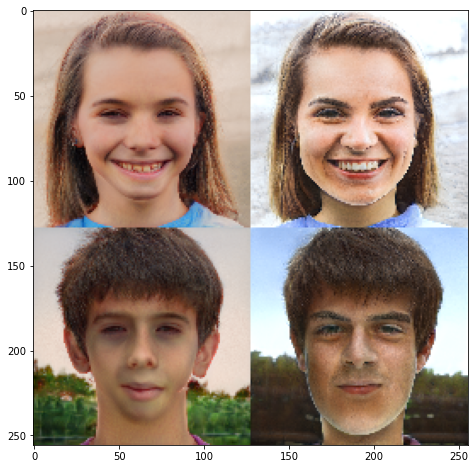

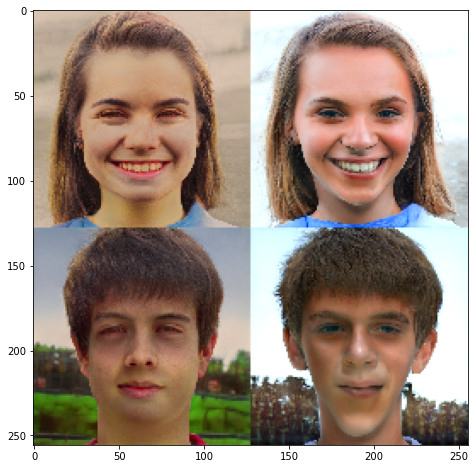

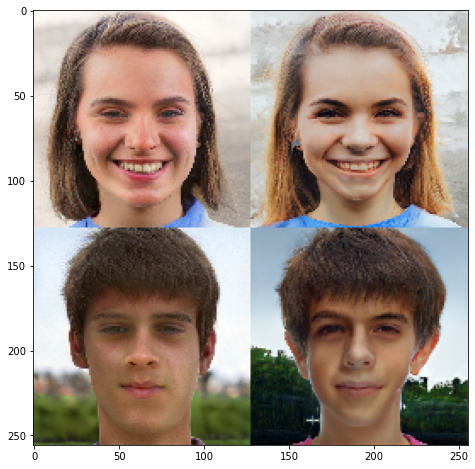

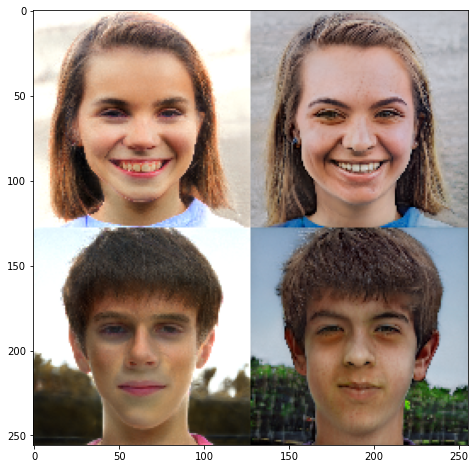

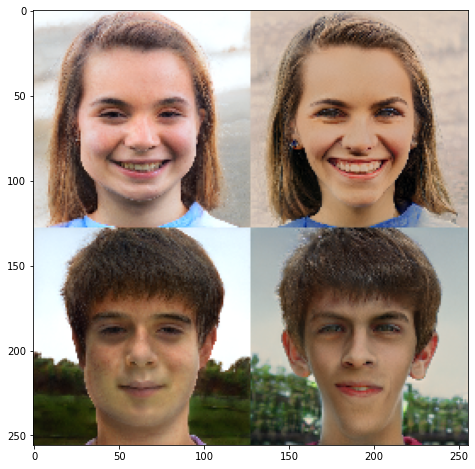

In [7]:
if task == 'face_boundary_act_fl_sup_fl_bp':
    # Use seed = 8, zs_train = randn(3, 512) and train with zs_train[:2] (Asian kid and a girl)
    for space, magnitude in zip(['s'], [25]): # zip(['s', 'w+', 'w', 'z'], [8, 2, 2, 1]):
        dataloader = dataloader_to(zs0[[31]], space)
        segmenter = FaceSegmenter(segmenter_path, mask_labels=range(1, 19), morphology='erosion', ks_ratio=0.05).to(device)
        f_fl_boundary = LandmarkMSE(generator, space, detector, range(0, 17)).to(device)
        f_bp = LandmarkInterpolationMSE(generator, space, detector, segmenter, (64, 64)).to(device)

        JtJs_fl_boundary = load_or_compute(cache_path % (space, task, 'fl_boundary'), lambda: find_jtj_direct(f_fl_boundary, dataloader), recompute=False, map_location=device)
        JtJs_bp = load_or_compute(cache_path % (space, task, 'bp'), lambda: find_jtj_direct(f_bp, dataloader), recompute=False, map_location=device)
        
        with torch.no_grad():
            s_act, v_act = compute_early_projected_pca( JtJs_fl_boundary[0], [JtJs_fl_boundary[1], JtJs_bp[0]], sup_ratio=[1e-2, 3e-3])
            torch.save([s_act, v_act], span_path % (space, task))
            visualize(zs0[[21, 31]], space, magnitude, v_act, steps=[-1, 1], selector=range(5))

In [8]:
if task == 'lip_photo_s_act_mp_sup_mp':
    for space, magnitude in zip(['s'], [20]): # zip(['s', 'w+', 'w', 'z'], [8, 2, 2, 1]):
        dataloader = dataloader_to(zs0[:2], space)
        nose_segmenter = FaceSegmenter(segmenter_path,
                mask_labels=[12, 13], morphology='dilation', ks_ratio=0.01).to(device)
        f_photo = MaskedMSE(generator, space, nose_segmenter, (128, 128))
        f_landmark = RelativeLandmarkMSE(generator, space, detector, range(48, 68)).to(device)
    
        JtJs_landmark = load_or_compute(cache_path % (space, task, 'landmark'), lambda: find_jtj_direct(f_landmark, dataloader), recompute=False, map_location=device)
    
        JtJs_photo = load_or_compute(cache_path % (space, task, 'photo'), lambda: find_jtj_approx(f_photo, dataloader), recompute=False, map_location=device)
        with torch.no_grad():
            s_act, v_act = compute_early_projected_pca(JtJs_photo[0],[JtJs_photo[1], JtJs_landmark[0]], sup_ratio=[1e-4, 1e-3])
    
            v_landmark_act = v_act
            torch.save([s_act, v_act], span_path % (space, task))
            visualize(zs0[[21, 30, 31]], space, magnitude, v_act, steps=[-1, 1], selector=range(10))

In [9]:
if task == 'eye_boundary_act_fl_sup_mp':
    for space, magnitude in zip(['s'], [20]):
        dataloader = dataloader_to(zs0[3:4], space)
        segmenter = FaceSegmenter(segmenter_path,
                mask_labels=[1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 17], morphology='erosion', ks_ratio=0.05).to(device)
        f_landmark = LandmarkMSE(generator, space, detector, range(36, 48)).to(device)
        f_mask = MaskedMSE(generator, space, segmenter, (64, 64))

        JtJs_landmark = load_or_compute(cache_path % (space, task, 'landmark'), lambda: find_jtj_direct(f_landmark, dataloader), recompute=True, map_location=device)
        JtJs_photo = load_or_compute(cache_path % (space, task, 'photo'), lambda: find_jtj_direct(f_mask, dataloader), recompute=True, map_location=device)
        
        with torch.no_grad():
            s_act, v_act = compute_early_projected_pca(JtJs_landmark[0],[JtJs_landmark[1], JtJs_photo[0]], sup_ratio=[1e-2, 2e-3])

            torch.save([s_act, v_act], span_path % (space, task))
            visualize(zs0[[31]], space, magnitude, v_act, steps=[-1, 1], selector=range(10))

In [10]:
if task == 'face_color_act_mp_sup_mp':
    for space, magnitude in zip(['s'], [15]): # zip(['s', 'w+', 'w', 'z'], [8, 2, 2, 1]):
        dataloader = dataloader_to(zs0[3:4], space)
        segmenter = FaceSegmenter(segmenter_path, mask_labels=[1, 7, 8, 10, 14]).to(device)
        f_color = RegionColorMSE(generator, space, segmenter, (64, 64))

        JtJs_color = load_or_compute(cache_path % (space, task, 'color'), lambda: find_jtj_direct(f_color, dataloader), recompute=False, map_location=device)
        
        with torch.no_grad():
            s_act, v_act = compute_early_projected_pca(JtJs_color[0], [JtJs_color[1]], sup_ratio=1e-3)
            torch.save([s_act, v_act], span_path % (space, task))
            visualize(zs0[[21]], space, magnitude, v_act, steps=[-1, 1], selector=range(5))

In [11]:
if task == 'mouth_shape_act_fl_sup_fl_mp':
    for space, magnitude in zip(['s'], [20]): # zip(['s', 'w+', 'w', 'z'], [8, 2, 2, 1]):
        dataloader = dataloader_to(zs0[:2], space)
        mask_labels = list(range(1, 19)); mask_labels.remove(11)
        head_segmenter = FaceSegmenter(segmenter_path, mask_labels=mask_labels, morphology='dilation', ks_ratio=0.05).to(device)
        mouth_segmenter = FaceSegmenter(segmenter_path, mask_labels=[11, 12, 13], morphology='dilation', ks_ratio=0.1).to(device)
        f_landmark = RelativeLandmarkMSE(generator, space, detector, range(48, 68)).to(device)
        f_interp = LandmarkInterpolationMSE(generator, space, detector, head_segmenter, (48, 48)).to(device)
        f_mp = MaskedMSE(generator, space, mouth_segmenter, (64, 64))

        JtJs_landmark = load_or_compute(cache_path % (space, task, 'landmark'), lambda: find_jtj_direct(f_landmark, dataloader), recompute=False, map_location=device)
        JtJs_blend = load_or_compute(cache_path % (space, task, 'blend'), lambda: find_jtj_direct(f_interp, dataloader), recompute=False, map_location=device)
        JtJs_mp = load_or_compute(cache_path % (space, task, 'mp'), lambda: find_jtj_direct(f_mp, dataloader), recompute=False, map_location=device)

        with torch.no_grad():
            s_act0, v_act0 = compute_projected_pca(JtJs_landmark[0],[JtJs_landmark[1], JtJs_blend[0]], [], early_sup_ratio=[1e-2, 1e-2])
            torch.save([s_act0, v_act0], span_path % (space, task))
            visualize(zs0[[31]], space, magnitude, v_act0, steps=[ -1, 1], selector=range(5))

In [12]:
if task == 'mouth_shape_act_fl_sup_fl_bp':
    for space, magnitude in zip(['s'], [20]): # zip(['s', 'w+', 'w', 'z'], [8, 2, 2, 1]):
        dataloader = dataloader_to(zs0[:2], space)
        mask_labels = list(range(1, 19)); mask_labels.remove(11)
        segmenter = FaceSegmenter(segmenter_path, mask_labels=mask_labels, morphology='dilation', ks_ratio=0.05).to(device)
        f_landmark = RelativeLandmarkMSE(generator, space, detector, range(48, 68)).to(device)
        f_interp = LandmarkInterpolationMSE(generator, space, detector, segmenter, (48, 48)).to(device)

        JtJs_landmark = load_or_compute(cache_path % (space, task, 'landmark'),
                lambda: find_jtj_direct(f_landmark, dataloader), recompute=False, map_location=device)
        JtJs_blend = load_or_compute(cache_path % (space, task, 'blend'),
                lambda: find_jtj_direct(f_interp, dataloader), recompute=False, map_location=device)

        with torch.no_grad():
            s_act, v_act = compute_late_projected_pca(
                    JtJs_landmark[0],[JtJs_landmark[1], JtJs_blend[0]], sup_ratio=[1e-2, 1e-2], act_ratio=2e-2)
        torch.save([s_act, v_act], span_path % (space, task))
        visualize(zs0[[21, 31]], space, magnitude, v_act, steps=[ -1, 1], selector=range(10))

In [13]:
if task == 'eye_photo_act_mp_sup_mp':
    for space, magnitude in zip(['s'], [20]): # zip(['s', 'w+', 'w', 'z'], [8, 2, 2, 1]):
        dataloader = dataloader_to(zs0[:2], space)
        nose_segmenter = FaceSegmenter(segmenter_path, mask_labels=[4, 5, 6], morphology='dilation', ks_ratio=0.1).to(device)
        f_photo = MaskedMSE(generator, space, nose_segmenter, (48, 48), return_complementary=True)

        JtJs_photo = load_or_compute(cache_path % (space, task, 'photo'), lambda: find_jtj_direct(f_photo, dataloader), recompute=False, map_location=device)
        with torch.no_grad():
            s_act, v_act = compute_early_projected_pca(JtJs_photo[0],[JtJs_photo[1]], sup_ratio=[1e-3])

            torch.save([s_act, v_act], span_path % (space, task))
            visualize(zs0[[21, 30]], space, magnitude, v_act, steps=[ -1, 1], selector=range(10))

In [14]:
if task == 'hair_photom_act_mp_sup_mp':
    for space, magnitude in zip(['s'], [16]): # zip(['s', 'w+', 'w', 'z'], [8, 2, 2, 1]):
        dataloader = dataloader_to(zs0[:2], space)
        nose_segmenter = FaceSegmenter(segmenter_path, mask_labels=[17], morphology='dilation', ks_ratio=0.2).to(device)
        f_photo = MaskedMSE(generator, space, nose_segmenter, (48, 48), return_complementary=True)

        JtJs_photo = load_or_compute(cache_path % (space, task, 'photo'), lambda: find_jtj_direct(f_photo, dataloader), recompute=False, map_location=device)
        with torch.no_grad():
            s_act, v_act = compute_early_projected_pca(JtJs_photo[0],[JtJs_photo[1]], sup_ratio=[2e-3])

            torch.save([s_act, v_act], span_path % (space, task))
            visualize(zs0[[21]], space, magnitude, v_act, steps=[ -1, 1], selector=range(10))